<a href="https://colab.research.google.com/github/garestrear/poligonal_clusterization/blob/master/SSPD_kmeans_poligonal_clusterization_definitivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Poligonal clusterization using kmeans with SSPD distance.

By Gustavo Restrepo. June 2020 

Modificado abril de 2021
##**Problem:**

We want to clusterizate a set of poligonal curves. All of this are standarized in such way that the first point is always (0,0) and the end point is (1,0). 

## **Principal Tools:**
### **1. kmeans**
K-Means is a very simple clustering algorithm (clustering belongs to unsupervised learning). Given a fixed number of clusters and an input dataset the algorithm tries to partition the data into clusters such that the clusters have high intra-class similarity and low inter-class similarity. Here we uses an easy and understandable implementation made for bantak (Git-Hub account of the code author).

#### Algorithm

1. Initialize the cluster centers, either randomly within the range of the input data or (recommended) with some of the existing training examples

2. Until convergence  

   2.1. Assign each datapoint to the closest cluster. The distance between a point and cluster center is measured using diferents distances.  

   2.2. Update the current estimates of the cluster centers by setting them to the mean of all instance belonging to that cluster  
   
   
#### Objective function

The underlying objective function tries to find cluster centers such that, if the data are partitioned into the corresponding clusters, distances between data points and their closest cluster centers become as small as possible.

Given a set of datapoints ${x_1, ..., x_n}$ and a positive number $k$, find the clusters $C_1, ..., C_k$ that minimize

\begin{equation}
J = \sum_{i=1}^n \, \sum_{j=1}^k \, z_{ij} \, || x_i - \mu_j ||_2
\end{equation}

where:  
- $z_{ij} \in \{0,1\}$ defines whether of not datapoint $x_i$ belongs to cluster $C_j$
- $\mu_j$ denotes the cluster center of cluster $C_j$
- $|| \, ||_2$ denotes the Euclidean distance

### Disadvantages of K-Means
- The number of clusters has to be set in the beginning
- The results depend on the inital cluster centers
- It's sensitive to outliers
- It's not guaranteed to find a global optimum, so it can get stuck in a local minimum


###**2. SSPD DISTANCE (Symmetric Segment-Path Distance) [1]:**
This is a modification of the Hausdorff distance. The authos shows a good behaviour of this distance when we are comparing trajectories (or poligonal curves).




  [1] P. Besse, B. Guillouet, J.-M. Loubes, and R. Francois, “Review and perspective for distance based trajectory clustering,” arXiv preprint arXiv:1508.04904, 2015.

# Es necesario instalar la libreria de distancia SSPD

In [1]:
%matplotlib inline
!pip install traj_dist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Processing /root/.cache/pip/wheels/69/63/0d/560a1741fa3f0ab897105cddb33f21f38c3330e4a57ea75db6/geohash2-1.1-cp37-none-any.whl
  Created wheel for traj-dist: filename=traj_dist-1.15-cp37-cp37m-linux_x86_64.whl size=1501014 sha256=8db045e38b278d1d7002981d61d02cd3c4eb561afb6fd8c6176050c8f66c1950
  Stored in directory: /root/.cache/pip/wheels/30/da/29/cfefc74eb8b6a6a8b3a1ff2609c988a781d7a7d6c791da5d55
Successfully built traj-dist


### Implementation
We should have to implement kmeans with the new distance SSPD

In [2]:
# %load kmeans.py
import matplotlib
import numpy as np
import traj_dist.distance as tdist
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import metrics
import scipy.io as spio
import scipy.cluster.hierarchy as sch
import pylab as pl
import pandas as pd
#from google.colab import drive
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score
matplotlib.rcParams.update({'font.size': 32})

class KMeans:
    
    def __init__(self, n_clusters=4):
        self.K = n_clusters
        
    def fit(self, X):
        #self.centroids = X[np.random.choice(len(X), self.K, replace=False),:]
        self.centroids = X[np.random.choice(len(X), self.K),:]

        self.intial_centroids = self.centroids
        self.prev_label,  self.labels = None, np.zeros(len(X))
        while not np.all(self.labels == self.prev_label) :
            self.prev_label = self.labels
            self.labels = self.predict(X)
            self.update_centroid(X)
        return self
        
    def predict(self, X):
        #return np.apply_along_axis(self.compute_label, 1, X)
        return np.apply_along_axis(self.compute_label, 1, X)


    def compute_label(self, x):
        k = len(self.centroids)
        l=int(np.round(len(x)/2))
        Tc=[]
        for i in range(k):
          ac=np.array(self.centroids[i,:l])
          bc=np.array(self.centroids[i,l:])
          traj=np.transpose(np.array([ac,bc]))
          Tc.append(traj)
        x2=numpy.matlib.repmat(x,k,1)
        Tx=[]
        for i in range(k):
          ax2=np.array(x2[i,:l])
          bx2=np.array(x2[i,l:])
          traj=np.transpose(np.array([ax2,bx2]))
          Tx.append(traj)
        cdist = tdist.cdist(Tc, Tx, metric="sspd")
        ind = np.unravel_index(np.argmin(cdist, axis=None), cdist.shape)
        return ind[0]
        #return np.argmin(tdist.cdist(self.centroids, x, metric="sspd"),axis=1)
    def update_centroid(self, X):
        self.centroids = np.array([np.mean(X[self.labels == k], axis=0)  for k in range(self.K)])

### DATA
We use a database with polygonal curves extracted by discretization of lemniscates, ellipses and hyperbolas. It has 25079 curves.



In [3]:
# Cargamos el repositorio git-hub que contine la base de datos
!git clone https://github.com/garestrear/poligonal_clusterization.git


Cloning into 'poligonal_clusterization'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 145 (delta 71), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (145/145), 57.00 MiB | 15.75 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [4]:
# 
mat=spio.loadmat('/content/poligonal_clusterization/BD_normalizada_unif_53179.mat',squeeze_me=True)
a=mat['curvasN'] # Es necesario convertirlos a tipo "complex" pues se cargan tipo str
X_numpy=np.array(a,dtype = np.complex) # luego los conver a tipo "array"

In [5]:
# Este código produce gráficos que se almacenan en el drive,
# debe montar la unidad
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Funciones adicionales


*   Función ***dist_pol***: para calcular la distancia de una poligonal a un conjunto
*   Función ***paint_cluster***: para pintar un cluster dado
* Función para calclar la longitud de las poligonales y usarlas para controlar la "semilla" en la clusterización



In [6]:
## Funciones creadas para este código

# función que calcula la distancia de una poligonal a un conjunto de poligonales 
# almacenadas como las finals de un array
def dist_pol(cpol1, MatPol):
    '''# Esta función calcula la distancia entre una poligonal y una matriz de poligonales
    úsela así [mean_dist, dist]=dist_pol(cpol1,MatPol) y obtenga la distancia promedio de 
    la poligonal a las demás poligonales del cluster y la distancia mínima '''
    r=MatPol-cpol1
    d2=np.apply_along_axis(np.linalg.norm,1,r)
    dist=min(d2)
    mean_dist=np.mean(d2)
    return mean_dist, dist
def dist_pol_SSPD(cpol1,MatPol):#self, x):
    k = len(MatPol)
    l=int(np.round(len(cpol1)/2))
    Tc=[]
    for i in range(k):
        ac=np.array(MatPol[i,:l])
        bc=np.array(MatPol[i,l:])
        traj=np.transpose(np.array([ac,bc]))
        Tc.append(traj)
    x2=numpy.matlib.repmat(cpol1,k,1)
    Tx=[]
    for i in range(k):
        ax2=np.array(x2[i,:l])
        bx2=np.array(x2[i,l:])
        traj=np.transpose(np.array([ax2,bx2]))
        Tx.append(traj)
    cdist = tdist.cdist(Tc, Tx, metric="sspd")
    ind = np.unravel_index(np.argmin(cdist, axis=None), cdist.shape)
    mean_distai=np.mean(np.mean(cdist,axis=0))
    min_distai=np.min(cdist)
    return mean_distai, min_distai
# Definimos una función que pinta un custer
def paint_cluster(ncluster,clusters_pack):
  '''# Use esta función así paint_cluster(ncluster,clusters_pack)
  # recuerde que para obtener clusters_pack use
  # clusters_pack= [X_numpy[labels==i] for i in range(cluster_number)]'''
  X_numpy_C=clusters_pack[ncluster]
  X=X_numpy_C.real
  Y=X_numpy_C.imag
  # Pintamos
  #plt.axis('equal')
  plt.plot(np.transpose(X),np.transpose(Y))
  plt.suptitle('Clúster ' +  str(ncluster) + ', N. poligonales: ' + str(len(X)),fontsize=28, fontweight='bold')

def longitudes_pol(Mat_pol):
    long_pol=list()
    for pol in Mat_pol:
        l=np.sum(np.abs(pol[0:-1]-pol[1:]))
        long_pol.append(l)
    return long_pol



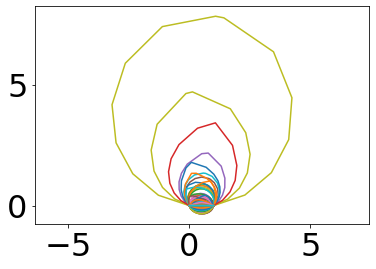

In [7]:
# Pintamos algunas de esas poligonales
N_curvas2paint=400;
a=np.random.randint(0,len(X_numpy), N_curvas2paint)
b=np.sort(a)
#print(b)
longitudes=longitudes_pol(X_numpy)
X=X_numpy.real
Y=X_numpy.imag
for k in b:
  plt.plot(X[k,0:15],Y[k,0:15])
  plt.axis('equal')
plt.show() 
# para guardarla en drive
#plt.savefig("/content/drive/MyDrive/Doctorado/chapter8_images/python_clusterization/sspd/figure_0.eps")


# Analisis de las poligonales según su longitud y reorganización. Extremos los ourliers


La longitud máxima es: 1.5238480233657947


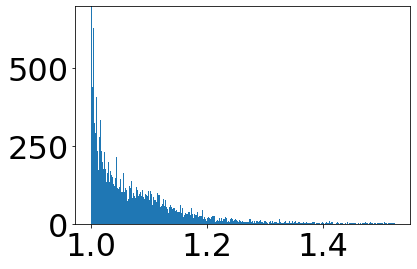

In [8]:
longitudes2=np.array(longitudes)
longitudes3 =np.sort(longitudes2)
sort_indices=np.argsort(longitudes2)
X_numpy_sort=X_numpy[sort_indices,:] # reorganización primero las mas cortas


a=0.95*len(X_numpy_sort)
indice_final=int(np.floor(a))
X_numpy_short=X_numpy_sort[range(indice_final),:]
# Hacemos de nuevo el histograma
longitudes4 =longitudes3[range(indice_final)]
plt.hist(longitudes4, bins=1000)
plt.ylim([0,700])
print('La longitud máxima es: '+ str(np.max(longitudes4)))
plt.show()
X_numpy=X_numpy_short

In [ ]:
#@title
'''# intento 2
longitudes2=np.array(longitudes)
longitudes3 =np.sort(longitudes2)
sort_indices=np.argsort(longitudes2)
X_numpy_sort=X_numpy[sort_indices,:] # reorganización primero las mas cortas

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(15, 15)
# graficamos histogramas haciendo zoom sobre ellos
axs[0,0].hist(longitudes3, bins=1000)

# graficamos el 99 % de ells
a=0.99*len(X_numpy_sort)
indice_final=int(np.floor(a))
longitudes4_1 =longitudes3[range(indice_final)]
axs[0,1].hist(longitudes4_1, bins=1000)

# graficamos el 95 % de ells
a=0.95*len(X_numpy_sort)
indice_final=int(np.floor(a))
X_numpy_short=X_numpy_sort[range(indice_final),:]
# Hacemos de nuevo el histograma
longitudes4_2 =longitudes3[range(indice_final)]
axs[0,2].hist(longitudes4_2, bins=1000)
#plt.ylim([0,700])

# graficamos el 95 % de ells
a=0.90*len(X_numpy_sort)
indice_final=int(np.floor(a))
#X_numpy_short=X_numpy_sort[range(indice_final),:]
# Hacemos de nuevo el histograma
longitudes4_3 =longitudes3[range(indice_final)]
axs[1,0].hist(longitudes4_3, bins=1000)


# graficamos el 95 % de ells
a=0.8*len(X_numpy_sort)
indice_final=int(np.floor(a))
#X_numpy_short=X_numpy_sort[range(indice_final),:]
# Hacemos de nuevo el histograma
longitudes4_4 =longitudes3[range(indice_final)]
axs[1,1].hist(longitudes4_4, bins=1000)
# graficamos el 90 %

# graficamos el 95 % de ells
a=0.5*len(X_numpy_sort)
indice_final=int(np.floor(a))
#X_numpy_short=X_numpy_sort[range(indice_final),:]
# Hacemos de nuevo el histograma
longitudes4_5 =longitudes3[range(indice_final)]
axs[1,2].hist(longitudes4_5, bins=1000)

#print('La longitud máxima es: '+ str(np.max(longitudes3)))
plt.show()

#plt.savefig("/content/drive/MyDrive/Doctorado/chapter8_images/python_clusterization/sspd/figure_1.eps", bbox_inches='tight')'''


'# intento 2\nlongitudes2=np.array(longitudes)\nlongitudes3 =np.sort(longitudes2)\nsort_indices=np.argsort(longitudes2)\nX_numpy_sort=X_numpy[sort_indices,:] # reorganización primero las mas cortas\n\nfig, axs = plt.subplots(2, 3)\nfig.set_size_inches(15, 15)\n# graficamos histogramas haciendo zoom sobre ellos\naxs[0,0].hist(longitudes3, bins=1000)\n\n# graficamos el 99 % de ells\na=0.99*len(X_numpy_sort)\nindice_final=int(np.floor(a))\nlongitudes4_1 =longitudes3[range(indice_final)]\naxs[0,1].hist(longitudes4_1, bins=1000)\n\n# graficamos el 95 % de ells\na=0.95*len(X_numpy_sort)\nindice_final=int(np.floor(a))\nX_numpy_short=X_numpy_sort[range(indice_final),:]\n# Hacemos de nuevo el histograma\nlongitudes4_2 =longitudes3[range(indice_final)]\naxs[0,2].hist(longitudes4_2, bins=1000)\n#plt.ylim([0,700])\n\n# graficamos el 95 % de ells\na=0.90*len(X_numpy_sort)\nindice_final=int(np.floor(a))\n#X_numpy_short=X_numpy_sort[range(indice_final),:]\n# Hacemos de nuevo el histograma\nlongitudes

# Construcción de un histograma en escala logaritmica

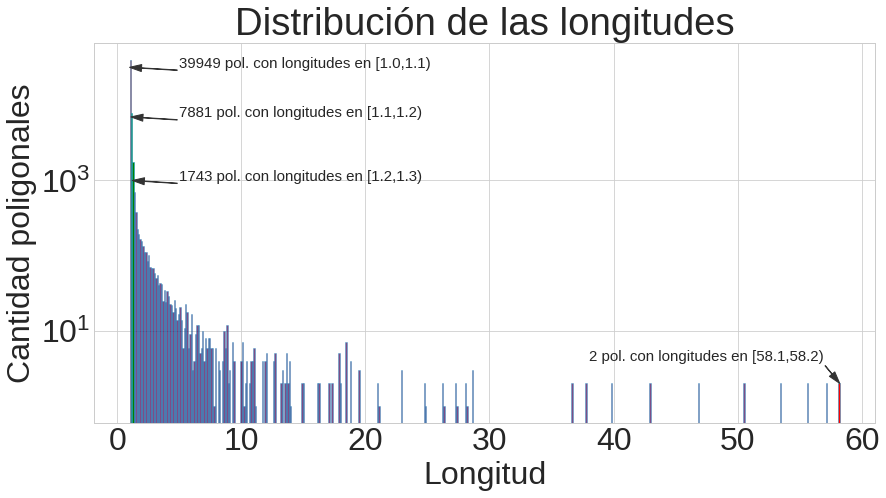

In [9]:
longitudes2=np.array(longitudes)
longitudes3 =np.sort(longitudes2)
sort_indices=np.argsort(longitudes2)
#X_numpy_sort=X_numpy[sort_indices,:] # reorganización primero las mas cortas

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
#plt.hist(x, bins=90, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
n, bins, patches=plt.hist(longitudes3, bins=500,log=True,facecolor = '#2ab0ff',\
                          edgecolor='#169acf', linewidth=0.5,alpha=0.7)
                          
n=n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
# Make one bin stand out   
patches[0].set_fc('red') # Set color
patches[0].set_alpha(1) # Set opacity


# Add annotation
plt.annotate(str(n[0]) + ' pol. con ' + 'longitudes en [' + str(round(bins[0],1) )+ 
             ',' + str(round(bins[1],1)) + ')' ,xy=(1,32000 ), xytext=(5,32000), 
             fontsize=15, arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})
# Add title and labels with custom font sizes
patches[1].set_fc('green') # Set color
patches[1].set_alpha(1) # Set opacity
plt.annotate(str(n[1]) + ' pol. con ' + 'longitudes en [' + str(round(bins[1],1) )+ 
             ',' + str(round(bins[2],1)) + ')' ,xy=(bins[1],7000 ), xytext=(5,7000), 
             fontsize=15, arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})

patches[2].set_fc('green') # Set color
patches[2].set_alpha(1) # Set opacity
plt.annotate(str(n[2]) + ' pol. con ' + 'longitudes en [' + str(round(bins[2],1) )+ 
             ',' + str(round(bins[3],1)) + ')' ,xy=(bins[2],1000 ), xytext=(5,1000), 
             fontsize=15, arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})

patches[-1].set_fc('red') # Set color
patches[-1].set_alpha(1) # Set opacity
plt.annotate(str(n[-1]) + ' pol. con ' + 'longitudes en [' + str(round(bins[-2],1) )+ 
             ',' + str(round(bins[-1],1)) + ')' ,xy=(bins[-1],2 ), xytext=(38,4), 
             fontsize=15, arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})


plt.title('Distribución de las longitudes') 
plt.xlabel('Longitud') 
plt.ylabel('Cantidad poligonales') 
#plt.yticks([0,5,10,50,100,500,1000,5000,10000,50000])
plt.show()

#plt.savefig("/content/drive/MyDrive/Doctorado/chapter8_images/python_clusterization/sspd/figure_1.eps")


Según el histograma anterior un gran número de poligonales tienen longitudes entre 1 y 1.5. Por lo anterior no es conveniente incluir las poligonales con mayor longitud en el proceso de clusterización. En palabras coloquiales estariamos introduciendo "ruido".

Clusterizamos el 95% de las curvas qu equivale a 50520 poligonales con poligonales que tienen longitudes entre 1.00 y 1.53


In [10]:
a=0.95*len(X_numpy_sort)
indice_final=int(np.floor(a))
X_numpy_short=X_numpy_sort[range(indice_final),:]
# Hacemos de nuevo el histograma
longitudes4 =longitudes3[range(indice_final)]
#plt.hist(longitudes4, bins=1000)
#plt.ylim([0,700])
print('La longitud máxima es: '+ str(np.max(longitudes4)))
#plt.show()
X_numpy=X_numpy_short



La longitud máxima es: 1.5238480233657947


Escogemos una muestra seudo aleatoria de las poligonales. Esto debido a que el proceso no puede aplicarse a todas

## **Gráficas de codo para determinar un  K  adecuado**
Calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS becomes first starts to diminish. In the plot of WSS-versus-k, this is visible as an elbow.
Within-Cluster-Sum of Squared Errors sounds a bit complex. Let’s break it down:


*   The Squared Error for each point is the square of the 
distance of the point from its representation i.e. its predicted cluster center.
* The WSS score is the sum of these Squared Errors for all the points.
* Any distance metric like the Euclidean Distance or the Manhattan Distance can be used.

**La gráfica reporta k=60 clusters como un número adecuado, ver https://github.com/garestrear/poligonal_clusterization/blob/master/poligonal_clusterization_kmeans_with_Euclidean_distance.ipynb.**

In [ ]:
#@title
'''WSS = []
X_numpy_r30=np.concatenate((X_numpy.real, X_numpy.imag),axis=1)

k_test = range(1,int(np.floor(len(X_numpy)/2)),int(np.floor(0.01*len(X_numpy))))

for k in k_test:
 kmeans_model_test = KMeans(n_clusters = k)
 kmeans_model_test.fit(X_numpy_r30)
 WSS.append(kmeans_model_test.inertia_)

plt.plot(k_test, WSS, 'bx-')
plt.xlabel("K")
plt.ylabel("WSS")
plt.title("Elbow graph")'''

'WSS = []\nX_numpy_r30=np.concatenate((X_numpy.real, X_numpy.imag),axis=1)\n\nk_test = range(1,int(np.floor(len(X_numpy)/2)),int(np.floor(0.01*len(X_numpy))))\n\nfor k in k_test:\n kmeans_model_test = KMeans(n_clusters = k)\n kmeans_model_test.fit(X_numpy_r30)\n WSS.append(kmeans_model_test.inertia_)\n\nplt.plot(k_test, WSS, \'bx-\')\nplt.xlabel("K")\nplt.ylabel("WSS")\nplt.title("Elbow graph")'

# Clusterization
Now we have the ingredients for the clusterization process. Lets make it real!

Se requiere realizarlo únicamente par aun muestreo, debido a las restricciones computacionales.

In [11]:
# Iniciamos el proceso de Clusterización
cluster_number=41
X_numpy_r30_2=np.concatenate((X_numpy.real, X_numpy.imag),axis=1)
poligonal_number=800
np.random.seed(5)
indices=np.sort(np.random.choice(len(X_numpy),poligonal_number))
X_numpy_r30=X_numpy_r30_2[indices,:]
X_numpy=X_numpy[indices,:]
#longitudes=longitudes4[0:poligonal_number]
#X=X_numpy_r30
kmeans_model =KMeans(n_clusters=cluster_number) # estimators=[('k_means_iris_150', KMeans(n_clusters=150))]
kmeans_model.fit(X_numpy_r30)
labels = kmeans_model.labels
#fignum = 1
#titles = ['kmeans + SSPD with 150 custers']
#estimators.fit(X)
kmeans_Silhuette_coefficient=metrics.silhouette_score(X_numpy_r30,labels,metric='euclidean')

#print(labels)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


## **Cálculo de la cantidad de curvas en cada cluster y reorganización de la clustrización**


In [12]:
labels2=labels
# algoritmo para reorganización de clusters
labels_aux=labels
X_numpy2=X_numpy#[indices,:]
for k in range(cluster_number-1):
  for j in range(k+1,cluster_number):
    Numk=len(X_numpy2[labels_aux==k])
    Numj=len(X_numpy2[labels_aux==j])
    if Numk < Numj:
      a=labels_aux==j
      b=labels_aux==k
      labels_aux[a]=k
      labels_aux[b]=j
         
#print(labels_aux)
X_numpy_r30=np.concatenate((X_numpy2.real, X_numpy2.imag),axis=1)


# Cluster Visualization. 
Use la función 

 paint_cluster(ncluster,clusters_pack)

 Para pintar un cluster, 
 Haga uso de la siguiente celda

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

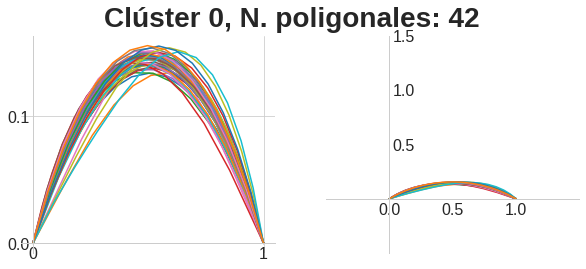

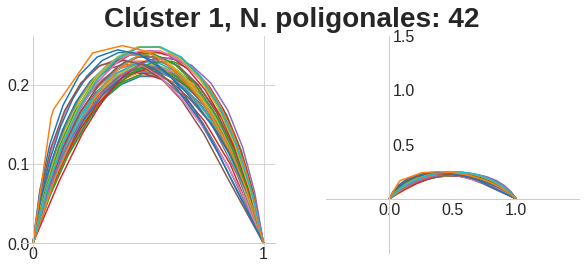

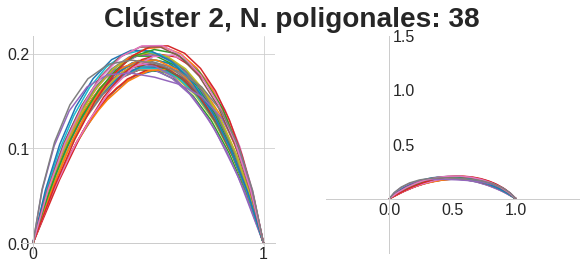

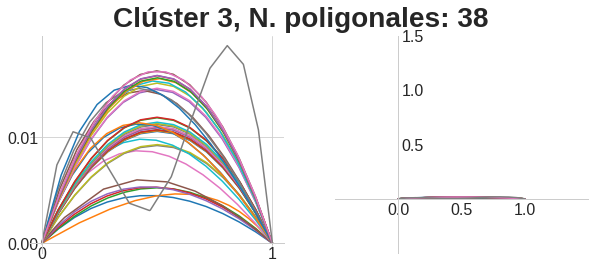

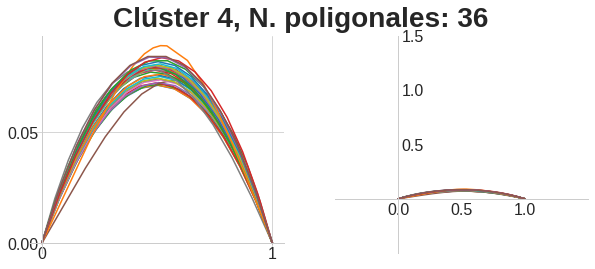

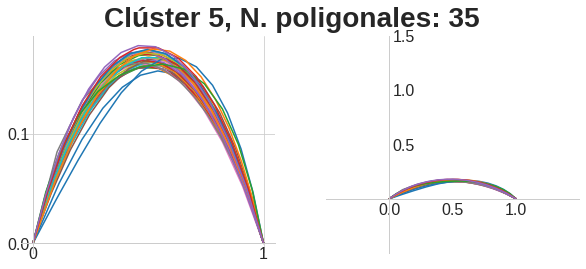

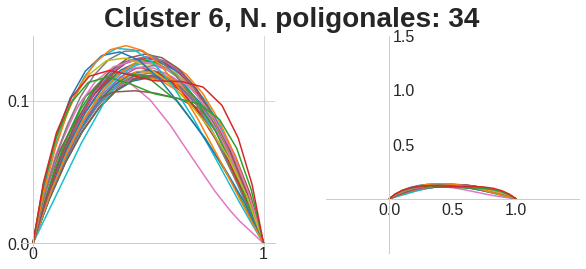

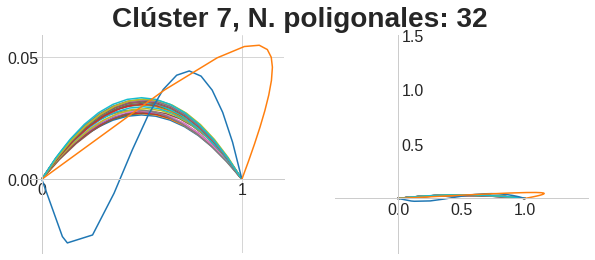

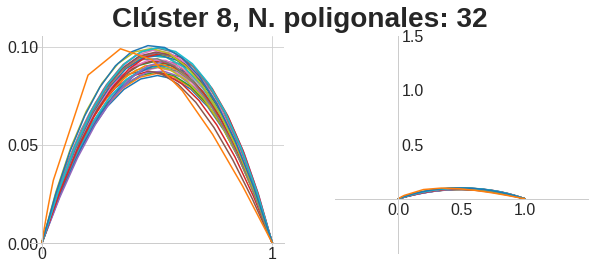

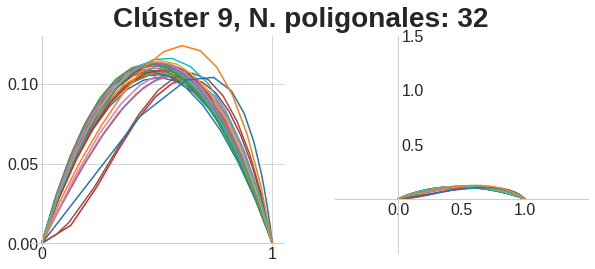

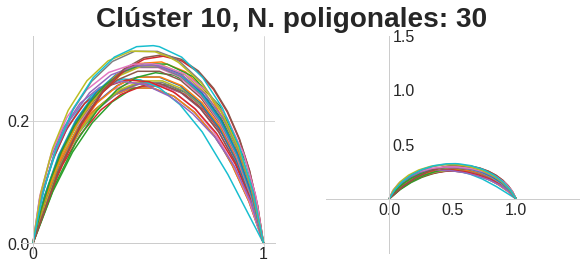

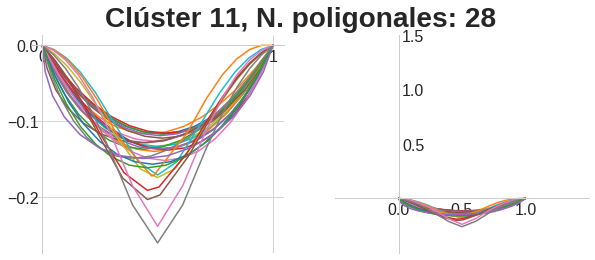

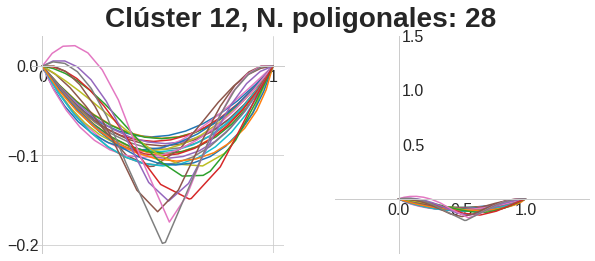

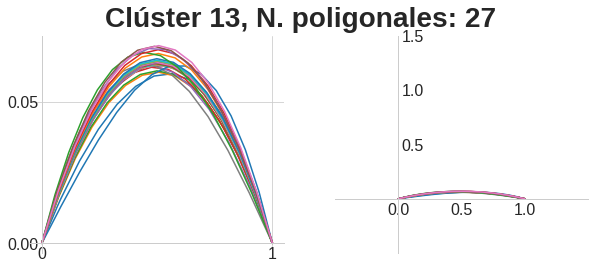

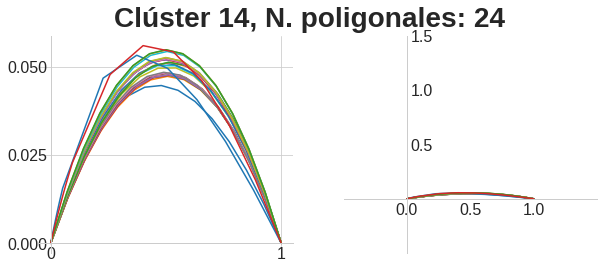

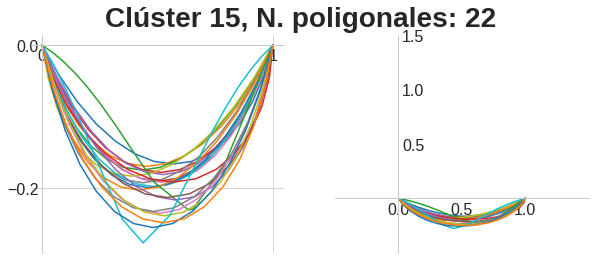

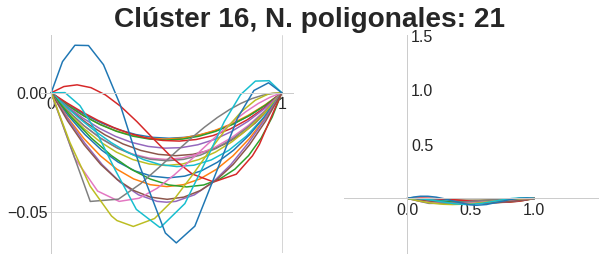

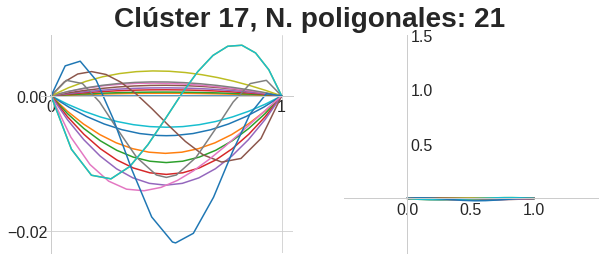

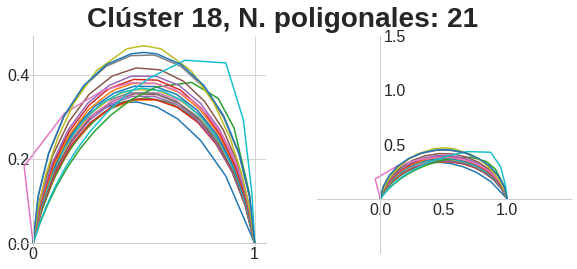

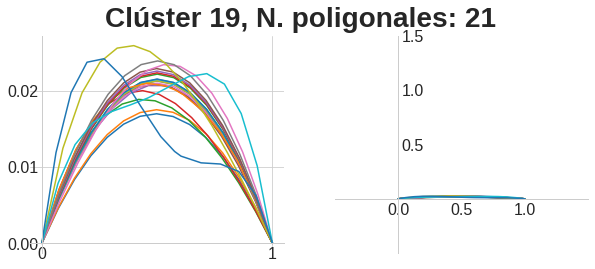

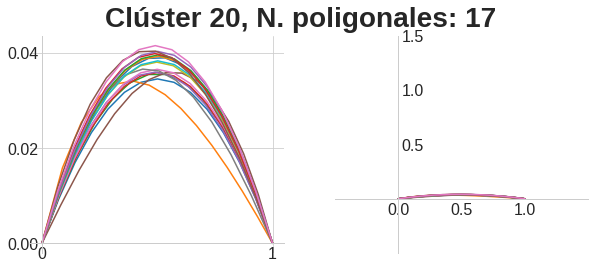

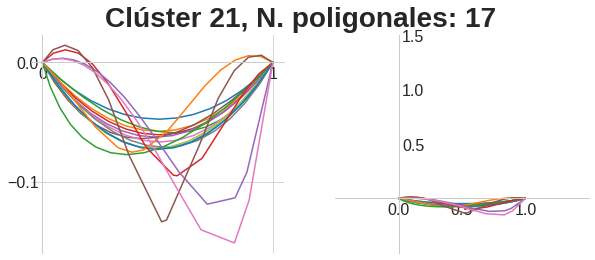

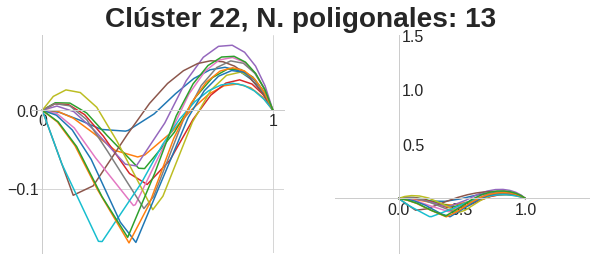

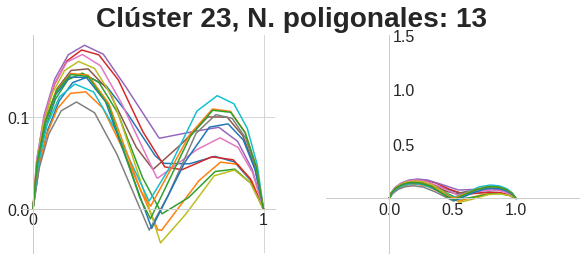

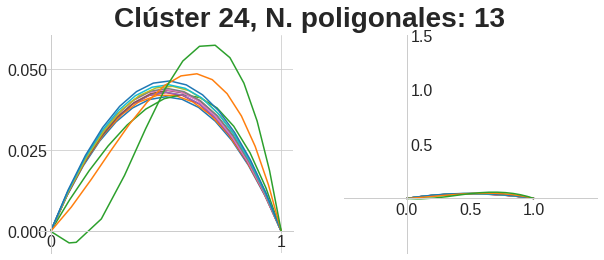

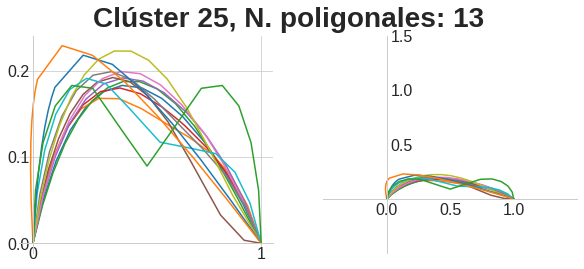

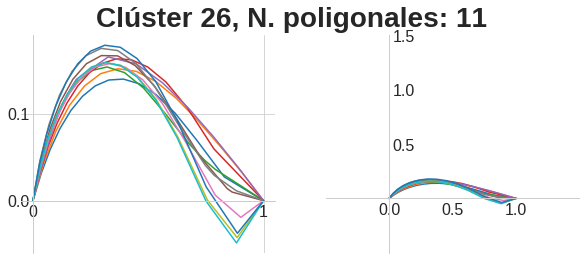

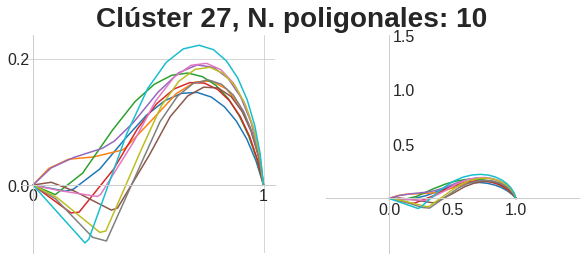

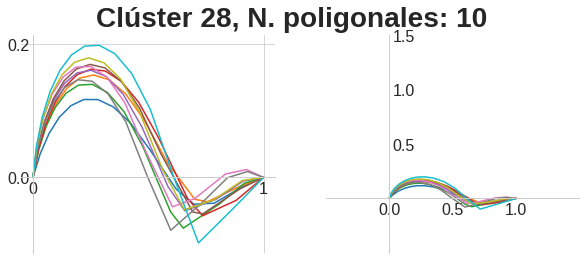

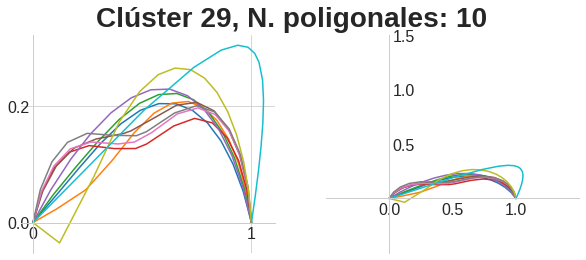

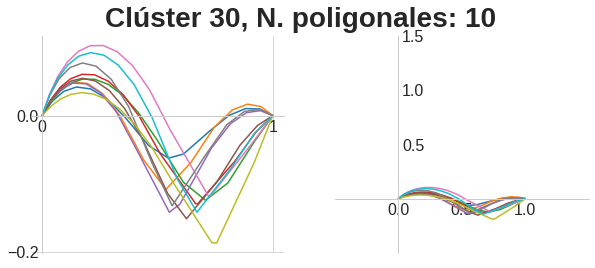

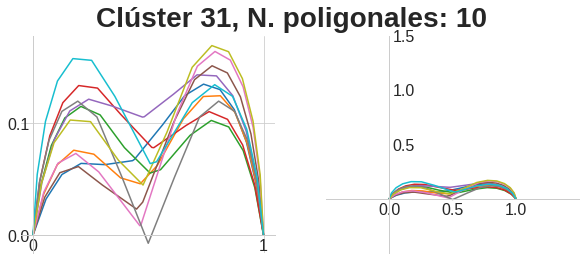

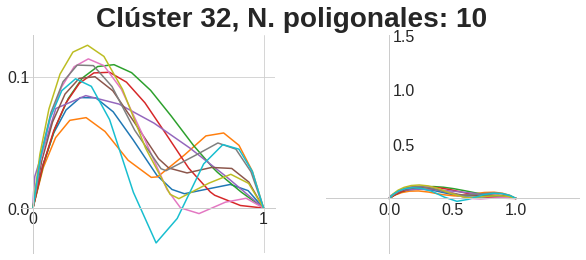

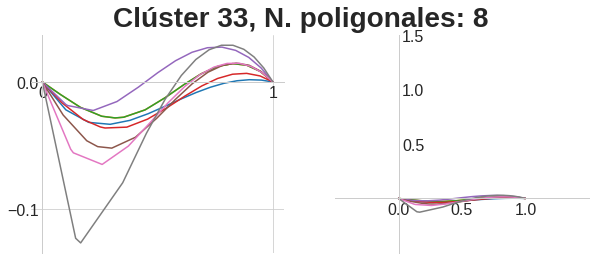

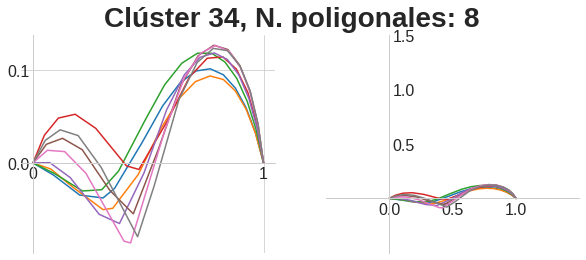

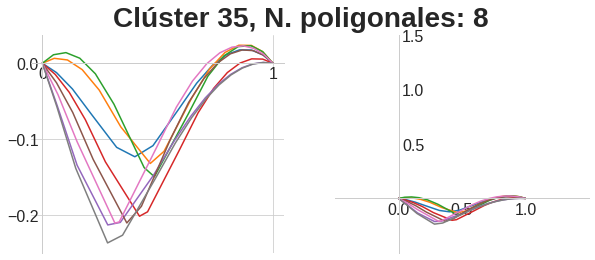

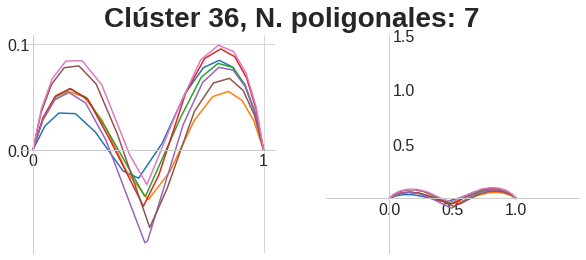

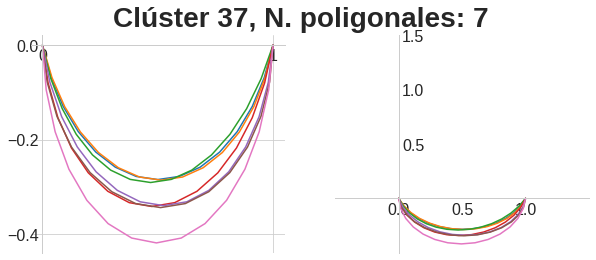

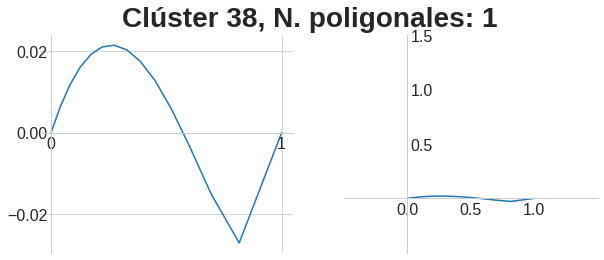

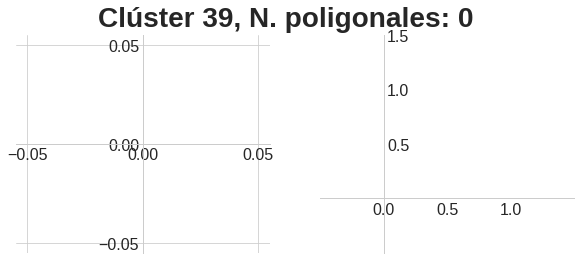

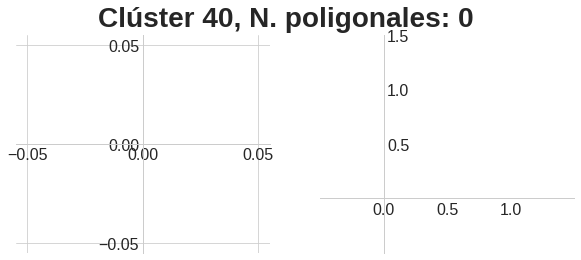

In [13]:
from pylab import *
clusters_pack2 = [X_numpy2[labels_aux==i] for i in range(cluster_number)]

for f in range(cluster_number):
  #figure(f), plt.figure(figsize=(14,7)) 
  fig = plt.figure(figsize=(10,4))
  #plt.title('Clúster número ' + str(f) + 'con' str())
  ax = fig.add_subplot(121)
  #plt.subplot(121)
  #ncluster=0 # Ponga el número del cluster que desea pintar
  paint_cluster(f,clusters_pack2)
  #plt.subplot(122)
  #paint_cluster(f,clusters_pack2)
  #plt.ylim([-0.2,1.5])
  
  #ax = fig.add_subplot(111)
  #ax.set_title('zeroed spines')
  #ax.plot(x, y)
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['top'].set_color('none')
# remove the ticks from the top and right edges
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')
  plt.yticks(fontsize=16)
  plt.xticks(fontsize=16)
  #plt.axis('equal')
  ax = fig.add_subplot(122)


  #plt.subplot(121)
  #ncluster=0 # Ponga el número del cluster que desea pintar
  paint_cluster(f,clusters_pack2)
  #plt.subplot(122)
  #paint_cluster(f,clusters_pack2)
  
  
  #ax = fig.add_subplot(111)
  #ax.set_title('zeroed spines')
  #ax.plot(x, y)
  ax.spines['right'].set_position('zero')
  ax.spines['left'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['top'].set_color('none')
  # remove the ticks from the top and right edges
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('right')
  ax.set_xticks([0, 0.5,1])
  ax.set_yticks([0.5,1,1.5])
  #ax.xticks([0.5,1])
  plt.yticks(fontsize=16)
  plt.xticks(fontsize=16)
  ax.grid(False)
  #plt.axis('equal')
  ax.set_xlim([-0.5,1.5])
  ax.set_ylim([-0.5,1.5])
  #ax.equal()
  #plt.show()
  #plt.axis('equal')

  nombre_imagen='/content/drive/MyDrive/Doctorado/chapter8_images/python_clusterization/sspd/figure_' + str(f+2) + '.eps'
  #plt.ylim([-0.25,1.5])
  #plt.savefig(nombre_imagen)

show()


# Silhuette analisis
The Silhouette Coefficient is a measure of how well samples are clustered with samples that are similar to themselves. Clustering models with a high Silhouette Coefficient are said to be dense, where samples in the same cluster are similar to each other, and well separated, where samples in different clusters are not very similar to each other.

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.
Explicación:
Suponga que se ha realizado una clusterización sobre la base de datos.
El silhouette coeff. (sc_i) se calcula para cada poligonal. Así:
Suponga que tomamos la poligonal i-ésima y que está en el cluster #k (Ck):

Paso 1. Se halla el promedio de las distancias de la poligonal i, a todas las poligonales contenidas en el mismo cluster (cluster Ck). Este número se denota por (a_i), i= desde 1 hasta #poligonales.

Paso 2. Se halla la distancia promedio de la poligonal i a las poligonales del cluster Cj, con j diferente de k y luego se toma el mínimo de estas distancias promedios. Este número se denota (b_i)
Observaciones.
Se espera que b_i > a_i. Caso contrario la poligonalestá mal ubicada (Hay un cluster en el que encajaría mejor).
El silhuette coeff (sc_i), es: (b_i-a_i)/max(b_i,a_i).
El denominador max(b_i,a_i) es un factor de normalización.
El caso ideal sería: todos los cluster cumplen que la distancia entre dos de sus elementos es siempre cero y por tanto a_i=0 y la distancia entre elementos de clusters diferentes es siempre mayor que cero. En este caso sc_i=1.
El peor caso es cuando dos elementos iguales quedan en diferente cluster y por tanto b_i=0 pero la distancia entre elementos del mismo cluster no es cero así a_i>0. En este caso sc_i=-1.
Finalmente el silhuette coeff. (sc) de la clusterización es (b-a)/max(a,b) donde b es promedio de los b_i y a es el promedio de los a_i.


The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.



## Silhuette coefficient for each cluster


### Sihuette coefficients for kmeans with Euclidean distance

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency;

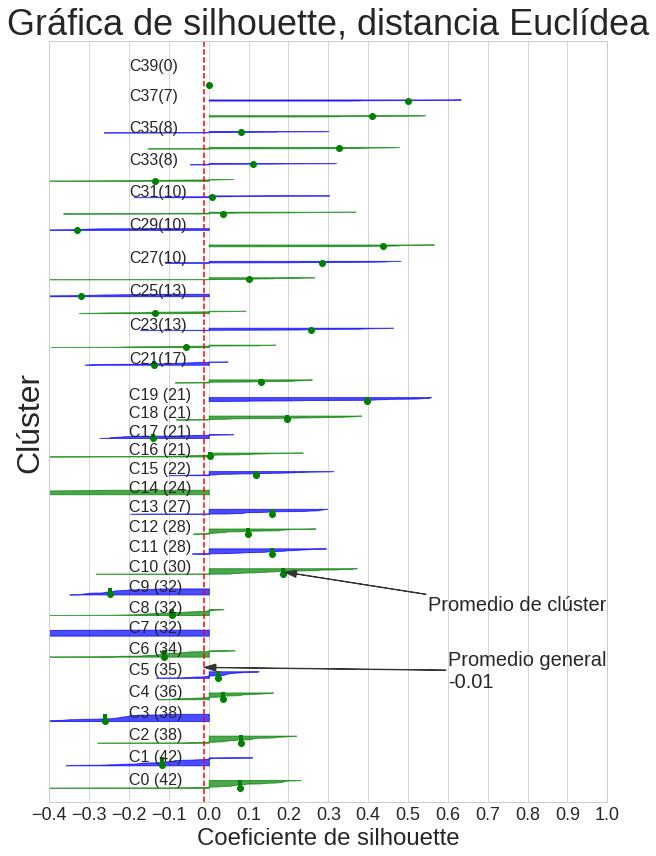

In [14]:
# Arriba se calculó
#hc_Silhuette_coefficient=metrics.silhouette_score(X_numpy_r30, labels, metric='euclidean')
kmeans_Silhuette_coefficient=metrics.silhouette_score(X_numpy_r30, labels_aux, metric='euclidean')


# El anterior número da cuenta de la calidad de la clusterización
silhouette_avg=kmeans_Silhuette_coefficient

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_numpy_r30, labels_aux)
#print(sample_silhouette_values)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(10, 14)
plt.style.use('seaborn-whitegrid') # nice and clean grid


    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
ax1.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
space_cluster=75
ax1.set_ylim([0, len(X_numpy2) + (cluster_number + 1) * space_cluster])
y_lower = space_cluster
color_option=['green', 'blue']
for i in range(cluster_number):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
      sample_silhouette_values[labels_aux == i]
    
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
  
    #color = cm.nipy_spectral(float(i) / cluster_number)  #Colormap type
    color=color_option[i % 2]
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    # Pintamos también el promedio de los coeficientes silhuette en cada cluster
    #ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    mpc=np.mean(sample_silhouette_values[labels_aux == i]) #mean per cluster
    #ax1.axvline(x=mpc, ymin=y_lower, ymax=y_lower+size_cluster_i, color="red", linestyle="--")
    ax1.plot([mpc, mpc],[y_lower, y_lower+size_cluster_i], \
             color="green", linestyle="--",linewidth=4)
   
   # Label the silhouette plots with their cluster numbers at the middle
    if size_cluster_i < 5:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+'('+str(size_cluster_i)+')',size=16)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 10:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+'('+str(size_cluster_i)+')',size=16)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 20:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+'('+str(size_cluster_i)+')',size=16)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 50:
      #if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' ('+str(size_cluster_i)+')',size=16)
        ax1.plot([mpc],[y_lower],'og')
      #else: 
       # ax1.plot([mpc],[y_lower],'og') 
    elif size_cluster_i < 100:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+'('+str(size_cluster_i)+')',size=16)
    elif size_cluster_i < 500:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+ '('+str(size_cluster_i)+')',size=23)
    elif size_cluster_i < 1000:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+'('+str(size_cluster_i)+')',size=31)
    else:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+'('+str(size_cluster_i)+')',size=36)

    # Compute the new y_lower for next plot
    y_lower = y_upper + space_cluster  # 10 for the 0 samples

ax1.set_title("Gráfica de silhouette, distancia Euclídea",fontsize=36)
#ax1.set_xlabel("The silhouette coefficient values",fontsize=36)
#ax1.set_ylabel("Cluster label",fontsize=36)

ax1.set_xlabel("Coeficiente de silhouette",fontsize=24)
ax1.set_ylabel("Clúster",fontsize=32)

    # The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.4,-0.3,-0.2,-0.1, 0, 0.1,0.2, 0.3,0.4,0.5, 0.6, 0.7,0.8,\
                    0.9, 1])
#plt.xticks(fontsize=16)
plt.xticks(fontsize=18)


# Add annotation
plt.annotate('Promedio general \n' + str(round(silhouette_avg,2)),xy=(silhouette_avg,700 ), xytext=(0.6,600), 
             fontsize=20, arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})
# Add annotation
plt.annotate('Promedio de clúster' ,xy=(0.19,1195 ), xytext=(0.55,1000), 
             fontsize=20, arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})
# ingresar manualmente el numero de la grafica
nombre_imagen='/content/drive/MyDrive/Doctorado/chapter8_images/python_clusterization/sspd/figure_' + str(43) + '.eps'
plt.savefig(nombre_imagen)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Silhouette analysis for kmeans clusterization with n_clusters = 41')

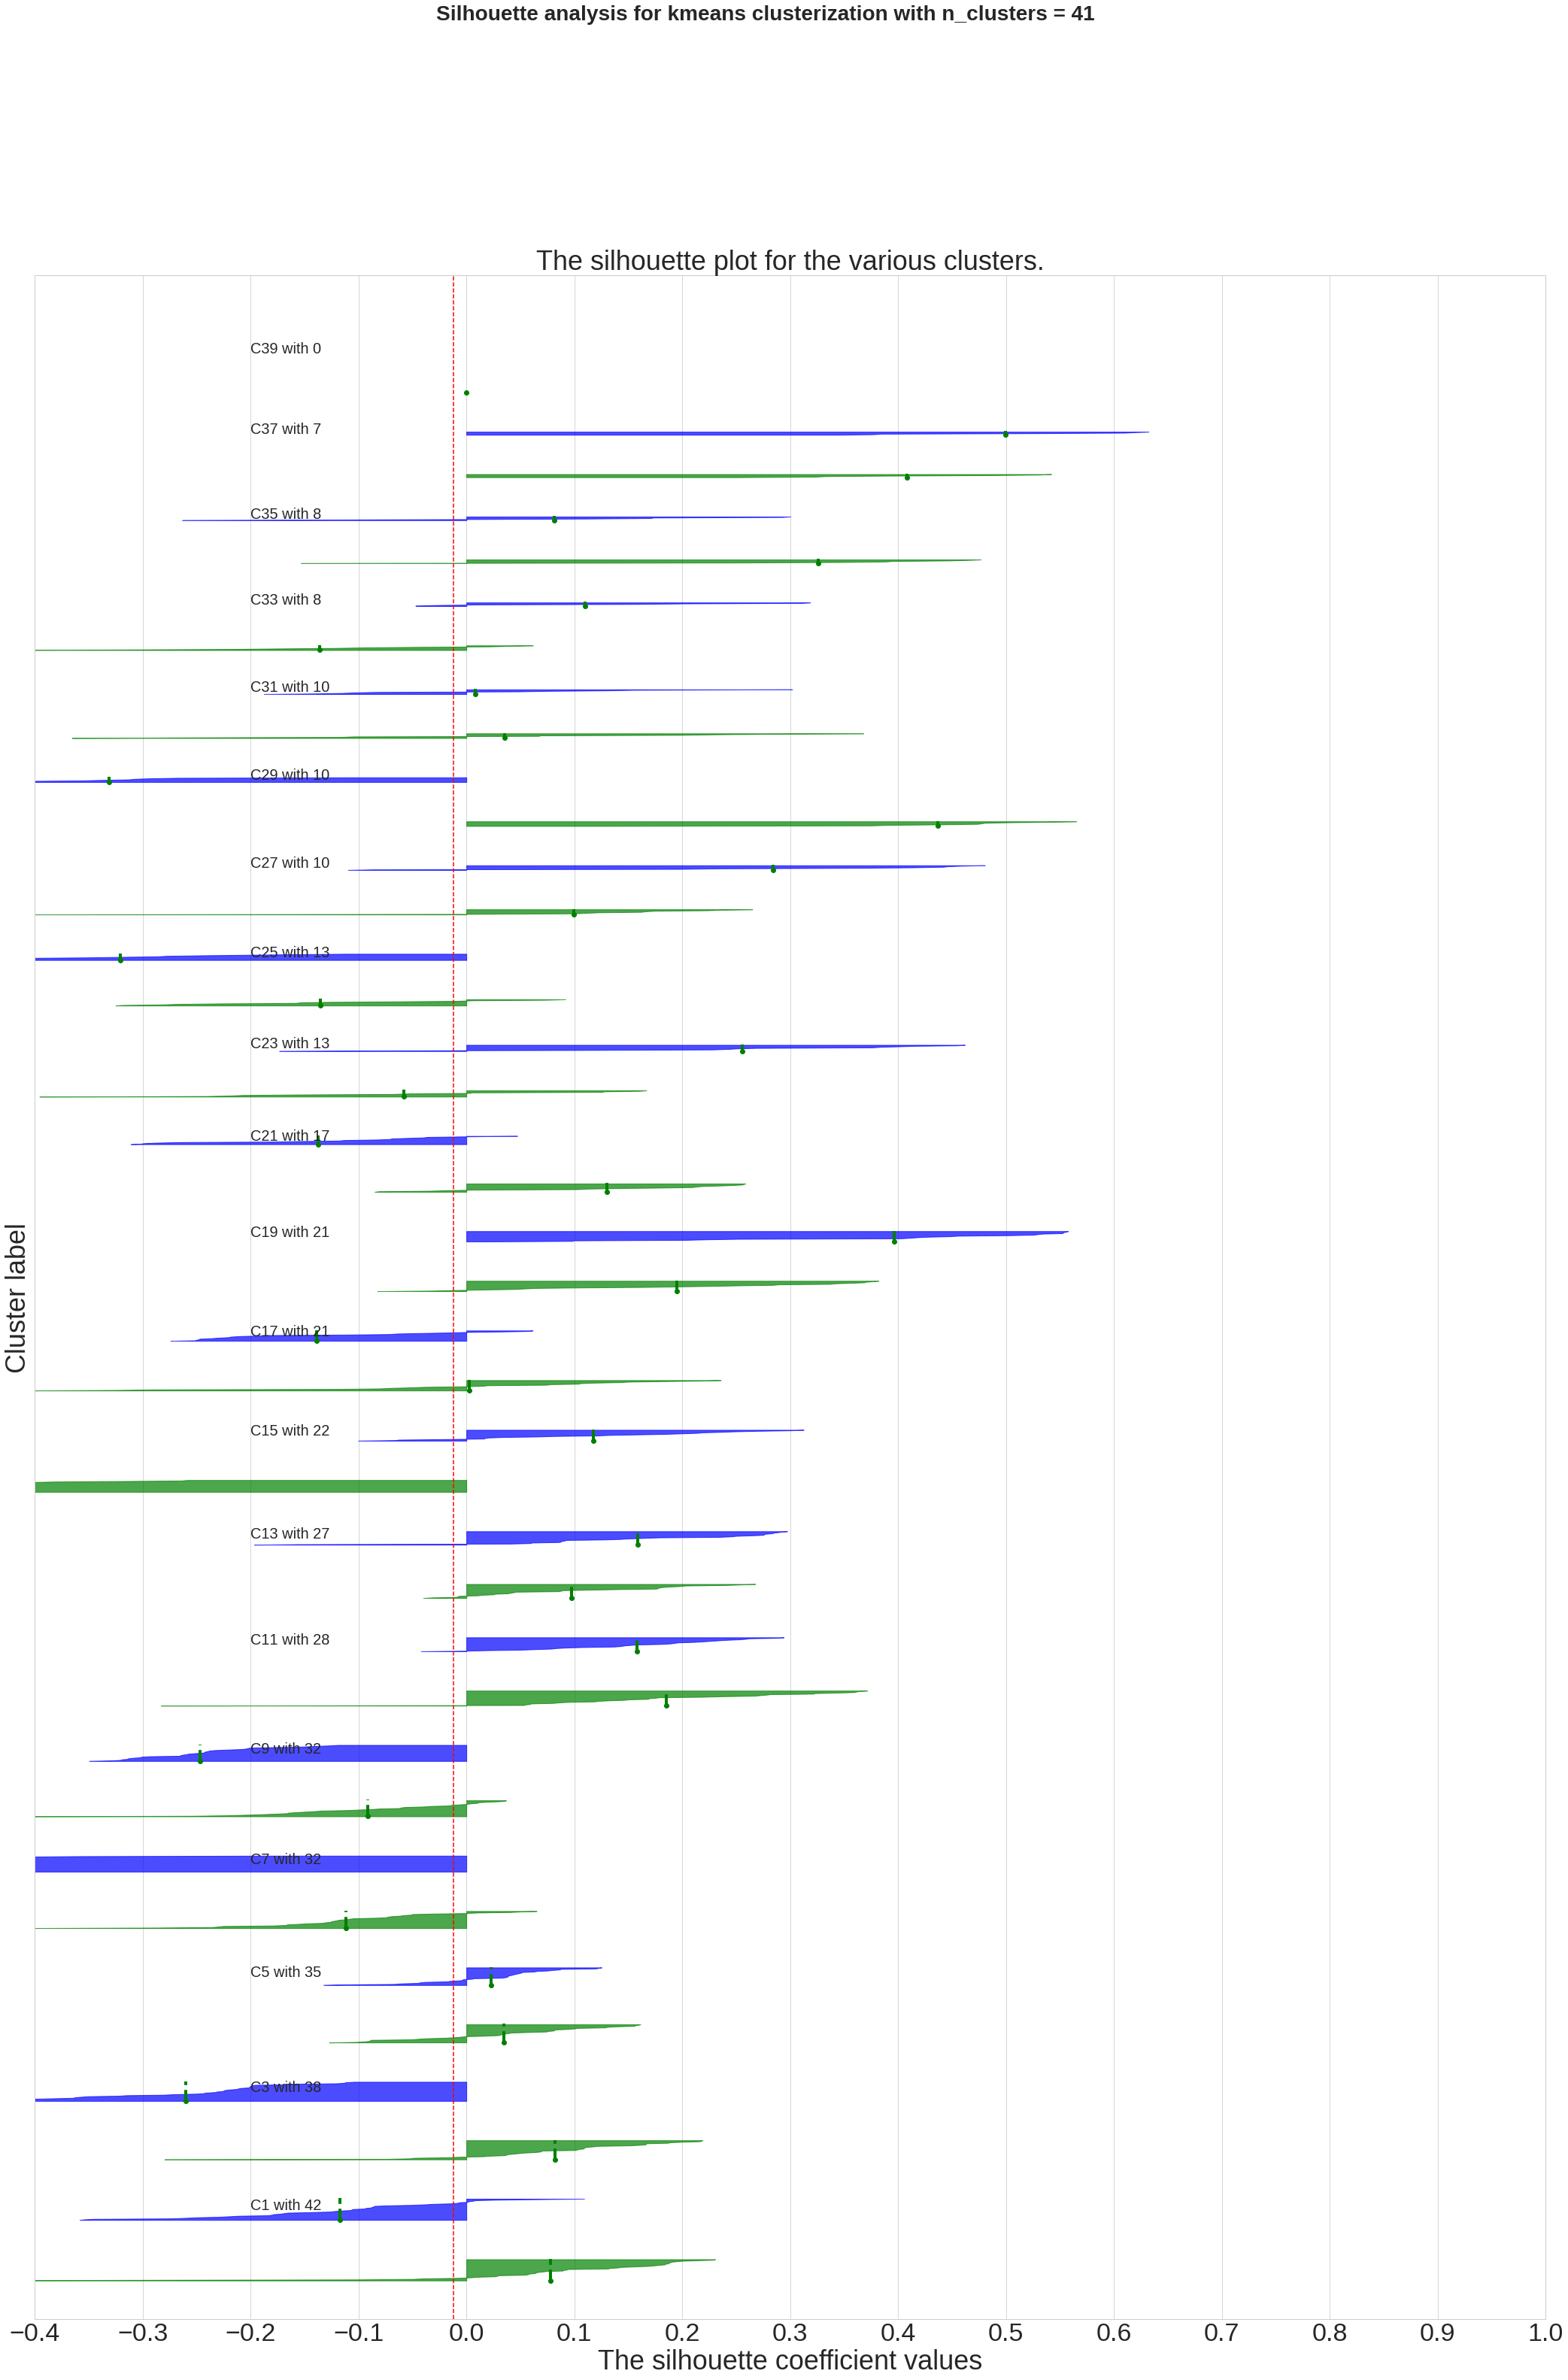

In [ ]:
#@title
'''# Arriba se calculó
#hc_Silhuette_coefficient=metrics.silhouette_score(X_numpy_r30, labels, metric='euclidean')
kmeans_Silhuette_coefficient=metrics.silhouette_score(X_numpy_r30, labels_aux, metric='euclidean')

# El anterior número da cuenta de la calidad de la clusterización
silhouette_avg=kmeans_Silhuette_coefficient

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_numpy_r30, labels_aux)
#print(sample_silhouette_values)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(36, 50)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
ax1.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
space_cluster=75
ax1.set_ylim([0, len(X_numpy2) + (cluster_number + 1) * space_cluster])
y_lower = space_cluster
color_option=['green', 'blue']
for i in range(cluster_number):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
      sample_silhouette_values[labels_aux == i]
    
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
  
    #color = cm.nipy_spectral(float(i) / cluster_number)  #Colormap type
    color=color_option[i % 2]
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    # Pintamos también el promedio de los coeficientes silhuette en cada cluster
    #ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    mpc=np.mean(sample_silhouette_values[labels_aux == i]) #mean per cluster
    #ax1.axvline(x=mpc, ymin=y_lower, ymax=y_lower+size_cluster_i, color="red", linestyle="--")
    ax1.plot([mpc, mpc],[y_lower, y_lower+size_cluster_i], \
             color="green", linestyle="--",linewidth=4)
   
   # Label the silhouette plots with their cluster numbers at the middle
    if size_cluster_i < 5:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 10:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 20:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 50:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else: 
        ax1.plot([mpc],[y_lower],'og') 
    elif size_cluster_i < 100:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
    elif size_cluster_i < 500:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=27)
    elif size_cluster_i < 1000:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=35)
    else:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=40)

    # Compute the new y_lower for next plot
    y_lower = y_upper + space_cluster  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.",fontsize=36)
ax1.set_xlabel("The silhouette coefficient values",fontsize=36)
ax1.set_ylabel("Cluster label",fontsize=36)

    # The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.4,-0.3,-0.2,-0.1, 0, 0.1,0.2, 0.3,0.4,0.5, 0.6, 0.7,0.8,\
                    0.9, 1])
#plt.xticks(fontsize=16)
plt.xticks(fontsize=34)
plt.suptitle(("Silhouette analysis for kmeans clusterization "
               "with n_clusters = %d" % cluster_number),
              fontsize=28, fontweight='bold')

 #plt.show()'''
   


### Sihuette coefficients for kmeans with SSPD distance

In [ ]:
#@title
# Ingredientes intra cluster
## labels  --> Contiene los indices de la clusterización, labels es un arreglo 
#              con la misma cantidad de elementos que poligonales. Cada entrada k de labels dice 
#              el indice del cluster al que pertenece la poligonal número k.
## X_numpy --> las poligonales en forma compleja
silhuette_a=[]
for i in range(len(X_numpy)):
  cpoli=X_numpy_r30[i,:]   # tomo una curva
  label_cpoli=labels_aux[i]      # miro a que cluster pertenece
  aux=labels_aux==label_cpoli    # Guardo los indices de las curvas que están en el mismo cluster
  aux[i]=False               # quito el indice de cpoli
  cluster_cpoli=X_numpy_r30[aux,:] # Tomo el cluster que contiene a la poligonal
  # Usamos la función que calcula distancias de una poligonal a una matriz de poligonales
  if len(cluster_cpoli)==0: # En este caso el cluster tiene una sola curva
    mean_distai=0
  else:
    [mean_distai,min_distai]=dist_pol_SSPD(cpoli, cluster_cpoli)
  
  #almacenamos estos coeficientes
  silhuette_a.append(mean_distai)


In [ ]:
#@title
# Ingredientes out cluster
## labels  --> Contiene los indices de la clusterización, labels es un arreglo 
#              con la misma cantidad de elementos que poligonales. Cada entrada k de labels dice 
#              el indice del cluster al que pertenece la poligonal número k.
## X_numpy --> las poligonales en forma compleja

silhuette_b=[]
for i in range(len(X_numpy)):
    cpoli=X_numpy_r30[i,:]   # tomo una curva
    label_cpoli=labels_aux[i]      # miro a que cluster pertenece
    silhuette_b_aux=[]
    for j in range(k):
        if j != label_cpoli:
            aux=labels_aux==j    # Guardo los indices de las curvas que están en el mismo cluster
            cluster_cpoli=X_numpy_r30[aux,:] #poligonales del cluster j
            # Usamos la función que calcula distancias de una poligonal a una matriz de poligonales
            if len(cluster_cpoli)==0: # En este caso el cluster tiene una sola curva
                mean_distai=0
            else:
                [mean_distai,min_distai]=dist_pol_SSPD(cpoli, cluster_cpoli)
            #almacenamos estos coeficientes
        silhuette_b_aux.append(mean_distai)
    silhuette_b.append(np.min(silhuette_b_aux))


In [15]:
# Con silhuette_a y silhuette_b construimos el coeficiente de silhuette para 
# cada poligonal,  El silhuette coeff (sc_i), es: (b_i-a_i)/max(b_i,a_i)
silhuette_SSPD=[]
for i in range(len(X_numpy)):
    a=silhuette_a[i]
    b=silhuette_b[i]  
    s=(b-a)/np.max([a,b])
    silhuette_SSPD.append(s)


sample_silhouette_values =np.array(silhuette_SSPD)
silhouette_avg=np.mean(sample_silhouette_values)
#print(sample_silhouette_values))


fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(10, 14)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
ax1.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
space_cluster=75
ax1.set_ylim([0, len(X_numpy2) + (cluster_number + 1) * space_cluster])
y_lower = space_cluster
color_option=['green', 'blue']
for i in range(cluster_number):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
      sample_silhouette_values[labels_aux == i]
    
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
  
    #color = cm.nipy_spectral(float(i) / cluster_number)  #Colormap type
    color=color_option[i % 2]
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    # Pintamos también el promedio de los coeficientes silhuette en cada cluster
    #ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    mpc=np.mean(sample_silhouette_values[labels_aux == i]) #mean per cluster
    #ax1.axvline(x=mpc, ymin=y_lower, ymax=y_lower+size_cluster_i, color="red", linestyle="--")
    ax1.plot([mpc, mpc],[y_lower, y_lower+size_cluster_i], \
             color="green", linestyle="--",linewidth=4)
   
   # Label the silhouette plots with their cluster numbers at the middle
    if size_cluster_i < 5:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+'('+str(size_cluster_i)+')',size=16)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 10:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+'('+str(size_cluster_i)+')',size=16)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 20:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+'('+str(size_cluster_i)+')',size=16)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 50:
      #if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' ('+str(size_cluster_i)+')',size=16)
        ax1.plot([mpc],[y_lower],'og')
      #else: 
       # ax1.plot([mpc],[y_lower],'og') 
    elif size_cluster_i < 100:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+'('+str(size_cluster_i)+')',size=16)
    elif size_cluster_i < 500:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+ '('+str(size_cluster_i)+')',size=23)
    elif size_cluster_i < 1000:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+'('+str(size_cluster_i)+')',size=31)
    else:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+'('+str(size_cluster_i)+')',size=36)

    # Compute the new y_lower for next plot
    y_lower = y_upper + space_cluster  # 10 for the 0 samples

#ax1.set_title("The silhouette plot for the various clusters.",fontsize=36)
#ax1.set_xlabel("The silhouette coefficient values",fontsize=36)
#ax1.set_ylabel("Cluster label",fontsize=36)
ax1.set_title("Gráfica de silhouette, distancia SSPD",fontsize=36)
ax1.set_xlabel("Coeficiente de silhouette",fontsize=24)
ax1.set_ylabel("Clúster",fontsize=32)

    # The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.4,-0.3,-0.2,-0.1, 0, 0.1,0.2, 0.3,0.4,0.5, 0.6, 0.7,0.8,\
                    0.9, 1])
#plt.xticks(fontsize=16)
plt.xticks(fontsize=18)
#plt.suptitle(("Silhouette analysis for kmeans clusterization "
#              "with n_clusters = %d" % cluster_number),
#              fontsize=28, fontweight='bold')
# Add annotation
plt.annotate('Promedio general \n' + str(round(silhouette_avg,2)) ,xy=(silhouette_avg,900 ), xytext=(0.6,800), 
             fontsize=20, arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})
# Add annotation
#plt.annotate('Promedio de clúster' ,xy=(0.19,1195 ), xytext=(0.55,1000), 
 #            fontsize=20, arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})
 #plt.show()
nombre_imagen='/content/drive/MyDrive/Doctorado/chapter8_images/python_clusterization/sspd/figure_' + str(44) + '.eps'
plt.savefig(nombre_imagen)  


NameError: ignored